We need some test cases for skewed, continuous, distributions. Simulating is not ideal, but at least it will give us some flexibility in offline testing

In [1]:
# import packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

from tqdm.auto import tqdm
from matplotlib import style

In [274]:
import datetime

In [2]:
sys.path.append('../../ab_testing_utils/')

In [3]:
import skewed_metric_utils

In [267]:
from typing import Union

In [4]:
# additional imports
import statsmodels.api as sm


In [5]:
# pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [6]:
# set plot style
style.use('fivethirtyeight')

In [7]:
# initialize tqdm for pandas
tqdm.pandas()

In [8]:
# We want a distribution which is (very) heavily skewed towards zero.  Let's try an exponential 
r = stats.expon.rvs(size=1000, scale=100000, loc=0)

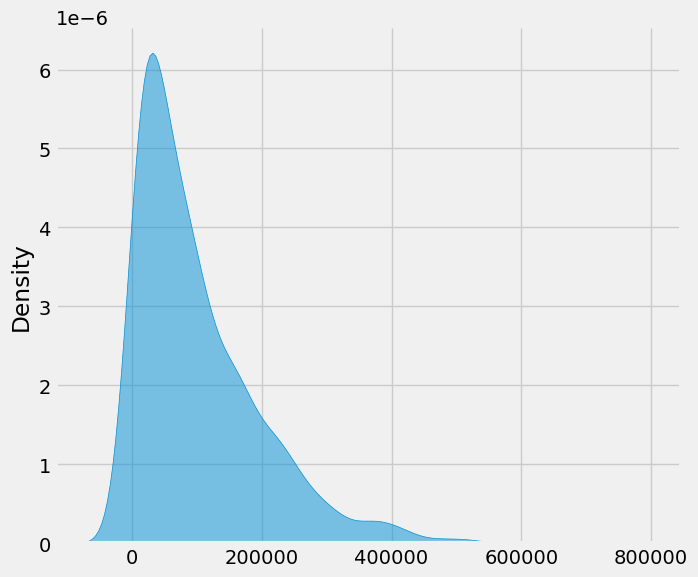

In [9]:
sns.displot(data=r, kind='kde', fill=True, alpha=0.5, height=6, aspect=1.2)

In [10]:
np.mean(r)

101684.71394258691

In [11]:
np.median(r)

73193.70947080088

In [12]:
# Hmm, not quite...how about a gamma? 
r = stats.gamma.rvs(size=10000, a=0.01, scale=10000)

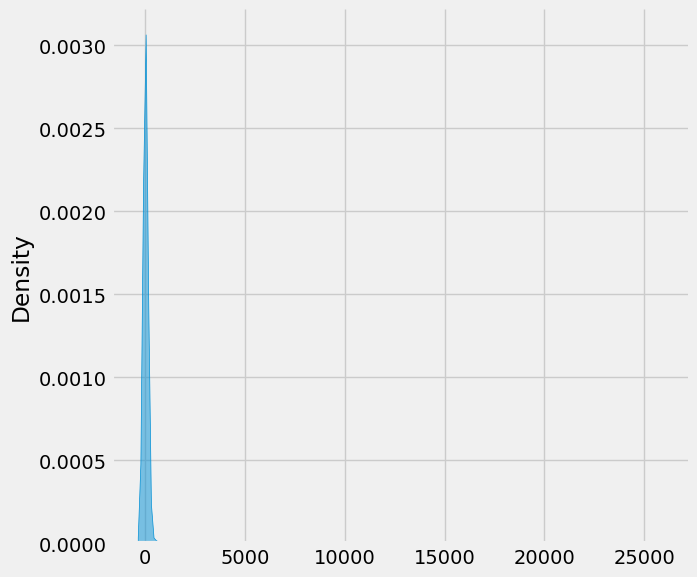

In [13]:
sns.displot(data=r, kind='kde', fill=True, alpha=0.5, height=6, aspect=1.2)

In [14]:
# This looks about right
np.mean(r)

78.76761951016668

In [15]:
np.median(r)

5.053944334055007e-27

In [16]:
# Yeah this will do :) 
df = pd.DataFrame()

In [17]:
df['gamma_sim'] = r

In [18]:
df.head()

,gamma_sim
0,1.541866e-36
1,1.388916e-01
2,4.596786e-20
3,1.353516e-24
4,1.516832e-25


In [19]:
df['gamma_sim'] = df['gamma_sim'].progress_apply(lambda x: np.round(x, 3))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
df['gamma_sim'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    10000.000000
mean        78.767615
std        778.143513
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.129100
95%         29.794600
99%       2023.500430
max      25514.456000
Name: gamma_sim, dtype: float64

In [21]:
# Oh yeah, this looks about right :D 

In [22]:
# OK let's try and generate another distribution which is slightly "better" in the sense that the distribution is the same, but there are a number of observations which are bigger

In [23]:
df['variant'] = 'control'

In [24]:
r_2 = stats.gamma.rvs(size=10000, a=0.01, scale=30000)

In [25]:
df_2 = pd.DataFrame()

In [26]:
df_2['gamma_sim'] = r_2
df_2['gamma_sim'] = df_2['gamma_sim'].progress_apply(lambda x: np.round(x, 3))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
df_2['variant'] = 'exposure'

In [28]:
df_all = pd.concat([df, df_2])

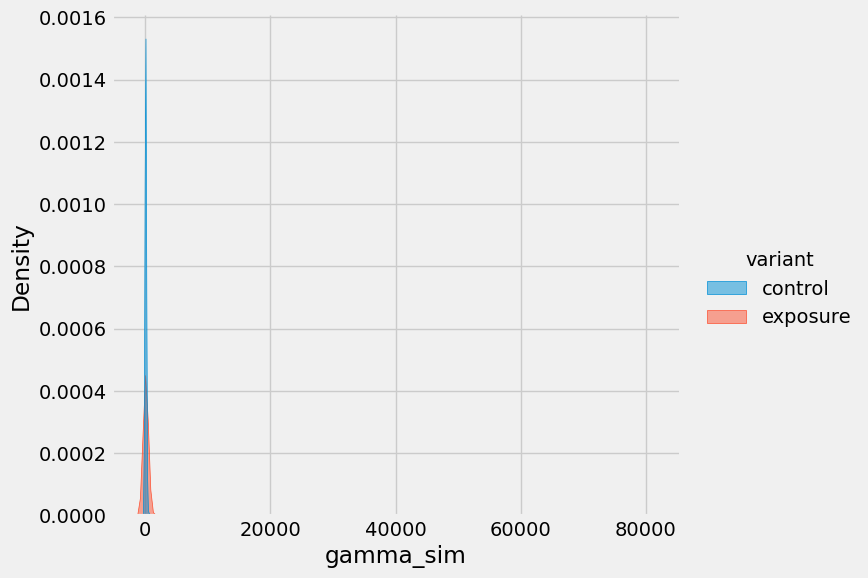

In [29]:
sns.displot(data=df_all, x='gamma_sim', hue='variant', kind='kde', fill=True, alpha=0.5, height=6, aspect=1.2)

In [30]:
df_all.groupby('variant')['gamma_sim'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
variant,,,,,,,,,,,
control,10000.0,78.767615,778.143513,0.0,0.0,0.0,0.0,0.1291,29.79460,2023.50043,25514.456
exposure,10000.0,314.407440,2681.422198,0.0,0.0,0.0,0.0,0.4316,104.30905,9771.71671,79923.359


<AxesSubplot: xlabel='variant', ylabel='gamma_sim'>

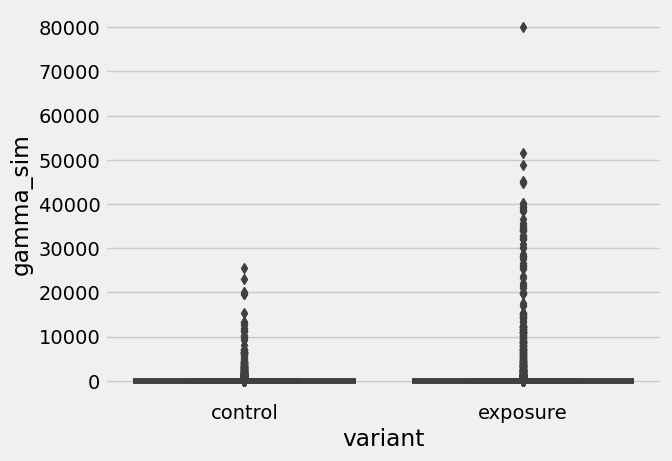

In [31]:
# Yeah ok, this looks potentially interesting
sns.boxplot(data=df_all, y='gamma_sim', x='variant')

In [32]:
# So let's look at the mean difference
df_all.query("variant=='exposure'")['gamma_sim'].mean() - df_all.query("variant=='control'")['gamma_sim'].mean()

235.63982419999996

In [33]:
# If I did a simple t-test
stats.ttest_ind(a=df_all.query("variant=='exposure'")['gamma_sim'].values, b=df_all.query("variant=='control'")['gamma_sim'].values, equal_var=False)

Ttest_indResult(statistic=8.439676528674823, pvalue=3.5566539671268335e-17)

In [34]:
# So this suggests a statistically significant difference.  

In [35]:
# How many observations are causing this? Try to bucket the non-zero observations. 
df_all.loc[(df_all['gamma_sim'] > 0)].head()

,gamma_sim,variant
1,0.139,control
12,0.009,control
13,999.019,control
26,1532.140,control
33,20.889,control


In [36]:
df_all.loc[(df_all['variant'] == 'control')]['gamma_sim'].describe()

count    10000.000000
mean        78.767615
std        778.143513
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      25514.456000
Name: gamma_sim, dtype: float64

In [37]:
df_all.loc[(df_all['gamma_sim'] >= 25514.456000)].groupby(['variant'], as_index=False).count()

,variant,gamma_sim
0,control,1
1,exposure,40


In [38]:
# So it looks like there are 40 observations in the exposure group which are bigger than or equal to the maximum value in the control group
# Actually, all of the observations in the exposure group are larger.
# These must be what is driving the difference? Let's see
df_all.loc[(df_all['gamma_sim'] > 25514.456000)].groupby(['variant'], as_index=False).count()

,variant,gamma_sim
0,exposure,40


In [39]:
df_all.loc[(df_all['gamma_sim'] <= 25514.456000)].groupby('variant').describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

gamma_sim                                                       \
             count        mean          std  min  25%  50%  75%     90%   
variant                                                                   
control    10000.0   78.767615   778.143513  0.0  0.0  0.0  0.0  0.1291   
exposure    9960.0  171.383074  1322.701300  0.0  0.0  0.0  0.0  0.3070   

                                           
               95%         99%        max  
variant                                    
control   29.79460  2023.50043  25514.456  
exposure  65.07015  6466.40910  25258.395

In [40]:
# The mean is still larger actually
stats.ttest_ind(a=df_all.loc[(df_all['gamma_sim'] <= 25514.456000)].query("variant=='exposure'")['gamma_sim'].values, 
                b=df_all.loc[(df_all['gamma_sim'] <= 25514.456000)].query("variant=='control'")['gamma_sim'].values, 
                equal_var=False)

Ttest_indResult(statistic=6.026107686099541, pvalue=1.7161511004567466e-09)

In [41]:
# Let's try out the randomization inference approach
ri_1 = skewed_metric_utils.RandomizationInference()

Running randomization inference...
Number of distinct assignment combinations practically too large. Running 1000 simulated permutations


  0%|          | 0/1000 [00:00<?, ?it/s]

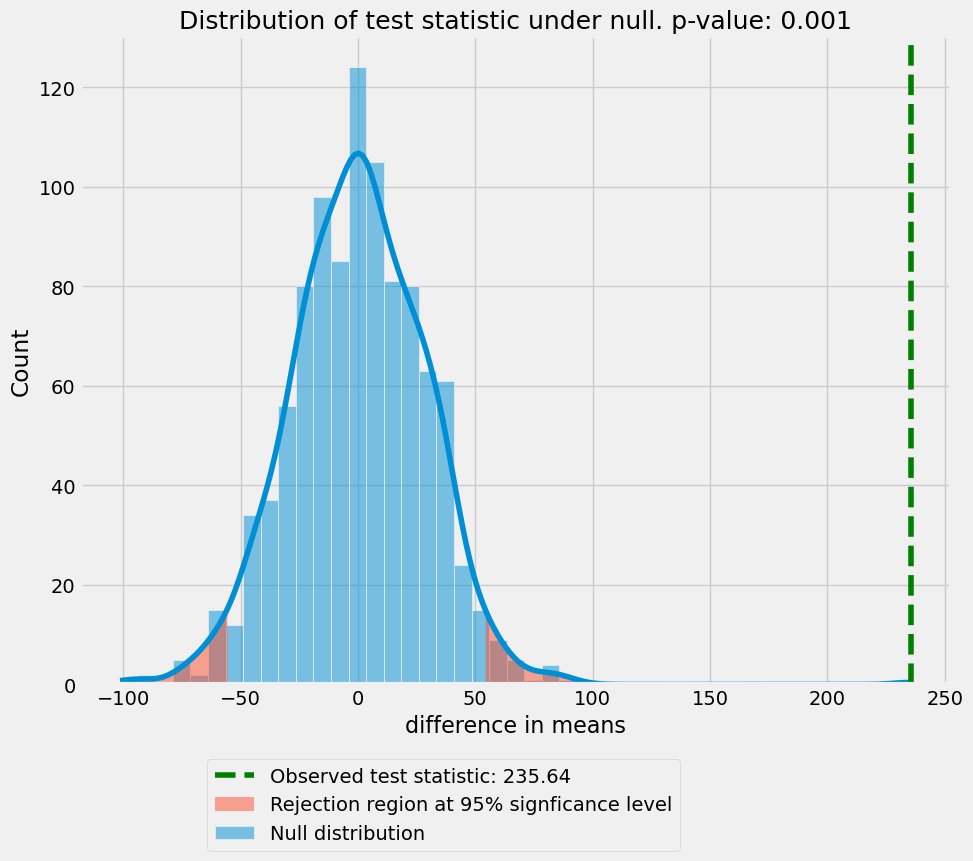

In [42]:
ri_1.experimental_analysis(df=df_all, outcome_column_name='gamma_sim', treatment_column_name='variant', treatment_name='exposure', control_name='control')

Running randomization inference...
Number of distinct assignment combinations practically too large. Running 1000 simulated permutations


  0%|          | 0/1000 [00:00<?, ?it/s]

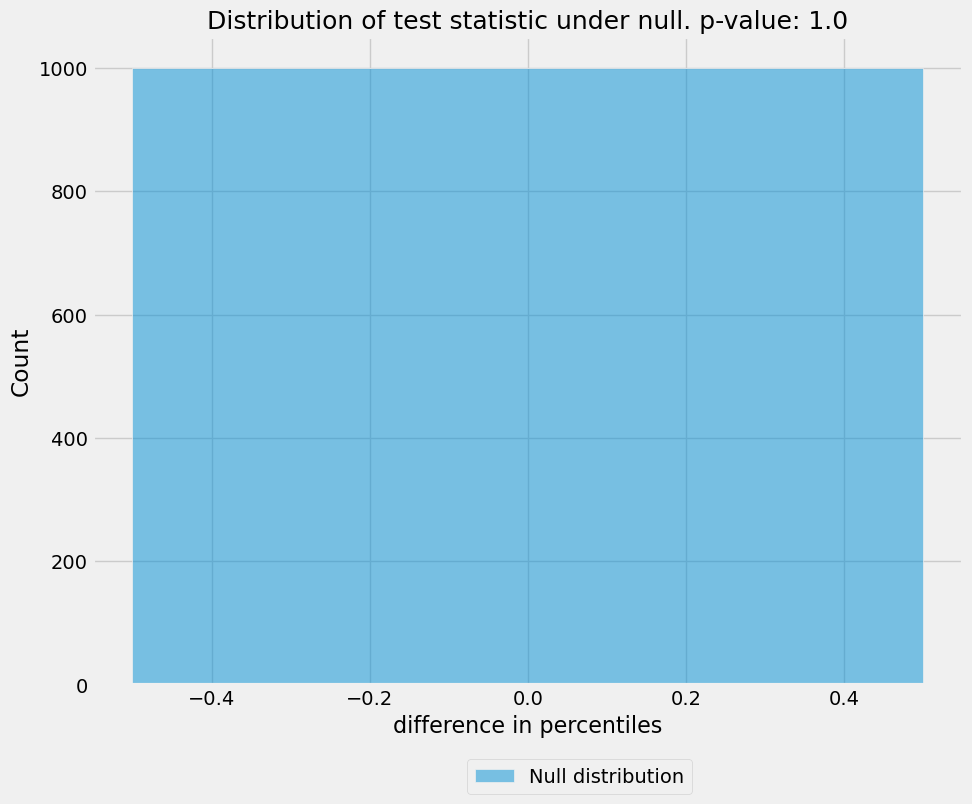

In [43]:
# So yeah, I mean this is strongly significant
# Test the median
ri_1.experimental_analysis(df=df_all, 
                           outcome_column_name='gamma_sim', 
                           treatment_column_name='variant', 
                           treatment_name='exposure', 
                           control_name='control', test_statistic={'function': 'difference_in_percentiles', 'params': {'quantile': 0.5}})

Running randomization inference...
Number of distinct assignment combinations practically too large. Running 1000 simulated permutations


  0%|          | 0/1000 [00:00<?, ?it/s]

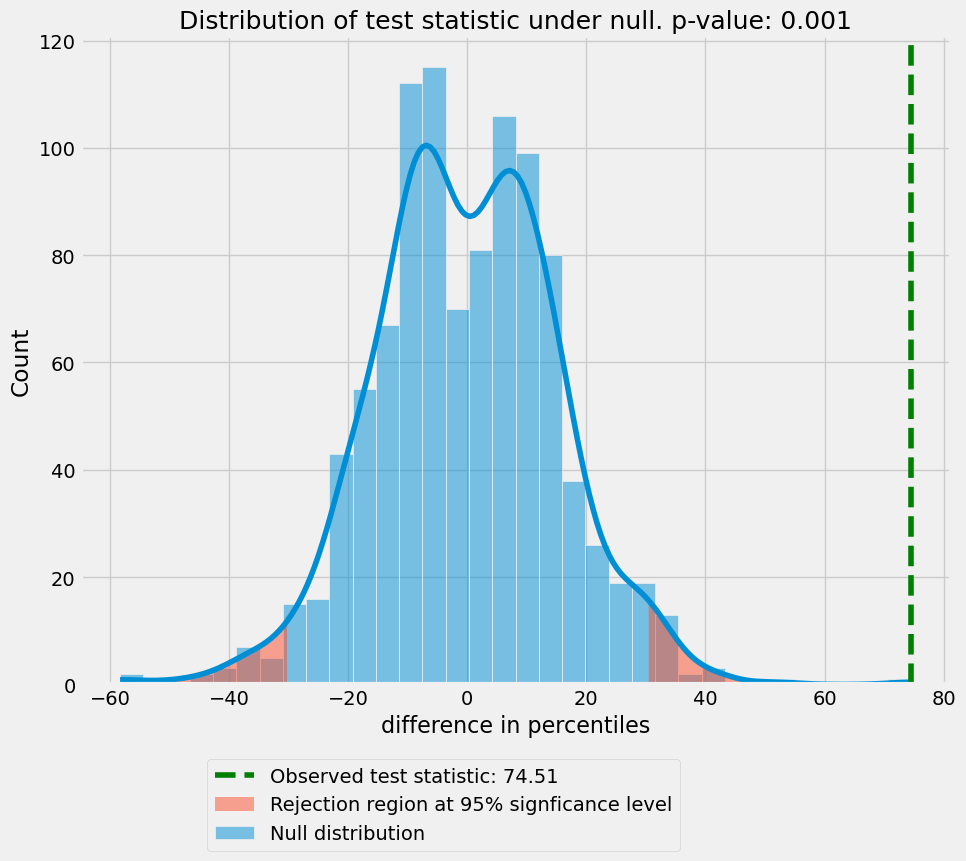

In [44]:
# Test the 95th percentile
ri_1.experimental_analysis(df=df_all, 
                           outcome_column_name='gamma_sim', 
                           treatment_column_name='variant', 
                           treatment_name='exposure', 
                           control_name='control', test_statistic={'function': 'difference_in_percentiles', 'params': {'quantile': 0.95}})

Running randomization inference...
Number of distinct assignment combinations practically too large. Running 1000 simulated permutations


  0%|          | 0/1000 [00:00<?, ?it/s]

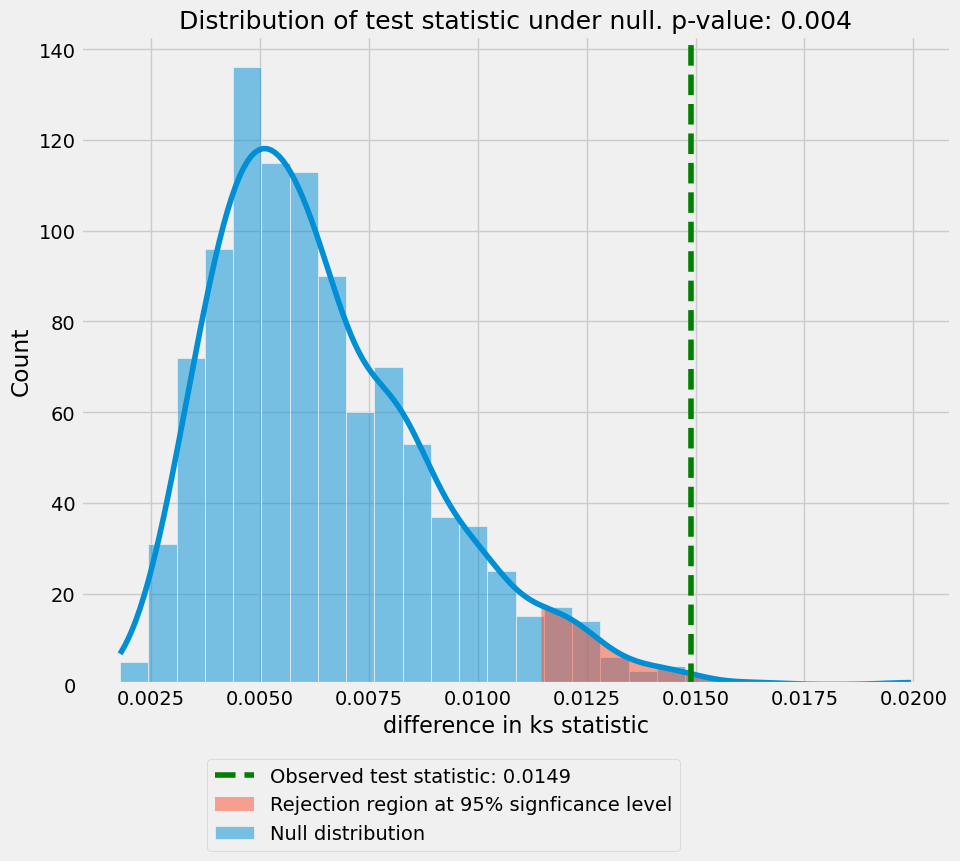

In [45]:
# Test the ks stat
# Yep, these are not the same distribution! 
ri_1.experimental_analysis(df=df_all, 
                           outcome_column_name='gamma_sim', 
                           treatment_column_name='variant', 
                           treatment_name='exposure', 
                           control_name='control', test_statistic={'function': 'difference_in_ks_statistic', 'params': None})

In [46]:
# mann-whitney. The exposure group should stochastically dominate the control
stats.mannwhitneyu(x=df_all.query("variant=='exposure'")['gamma_sim'].values, y=df_all.query("variant=='control'")['gamma_sim'].values)

MannwhitneyuResult(statistic=50552835.0, pvalue=0.03138715794499743)

In [47]:
# Yeah, the exposure group stochastically dominates the control, as we expected
df_all['buckets'] = pd.cut(df_all['gamma_sim'].values, bins=5, labels=False)

In [48]:
df_all.head()

,gamma_sim,variant,buckets
0,0.000,control,0
1,0.139,control,0
2,0.000,control,0
3,0.000,control,0
4,0.000,control,0


In [49]:
df_all.groupby(['variant', 'buckets'], as_index=False).count()

,variant,buckets,gamma_sim
0,control,0,9995
1,control,1,5
2,exposure,0,9945
3,exposure,1,27
4,exposure,2,25
5,exposure,3,2
6,exposure,4,1


In [50]:
df_all.groupby('buckets').agg({'gamma_sim': ['min', 'max', 'mean', 'median']})

gamma_sim                                     
               min        max          mean      median
buckets                                                
0            0.000  15452.222    104.188769      0.0000
1        17033.201  31032.137  23551.159781  23151.6590
2        32103.489  45287.639  36810.481800  35367.7040
3        48877.149  51526.840  50201.994500  50201.9945
4        79923.359  79923.359  79923.359000  79923.3590

In [51]:
# What can we do with this?
dummies_k_1 = pd.get_dummies(df_all['buckets'], drop_first=True)
dummies_k = pd.get_dummies(df_all['buckets'])

In [52]:
df_all_k = df_all.copy()
df_all_k = pd.concat([df_all_k, dummies_k], axis=1)

In [53]:
df_all_k.head()

,gamma_sim,variant,buckets,0,1,2,3,4
0,0.000,control,0,1,0,0,0,0
1,0.139,control,0,1,0,0,0,0
2,0.000,control,0,1,0,0,0,0
3,0.000,control,0,1,0,0,0,0
4,0.000,control,0,1,0,0,0,0


In [54]:
df_all_k_1 = df_all.copy()
df_all_k_1 = pd.concat([df_all_k_1, dummies_k], axis=1)

In [55]:
df_all_k['variant_binary'] = df_all_k['variant'].progress_apply(lambda x: 1 if x == 'exposure' else 0)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [56]:
df_all_k_1['variant_binary'] = df_all_k_1['variant'].progress_apply(lambda x: 1 if x == 'exposure' else 0)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [57]:
logit_k_1 = sm.Logit(df_all_k_1['variant_binary'], df_all_k_1[[0, 1, 2, 3, 4]])

In [58]:
results_k_1 = logit_k_1.fit()

         Current function value: 0.691758
         Iterations: 35


/Users/danielokeeffe/opt/miniconda3/envs/causal_ml_py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
results_k_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         variant_binary   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19995
Method:                           MLE   Df Model:                            4
Date:                Sat, 23 Mar 2024   Pseudo R-squ.:                0.002004
Time:                        13:48:24   Log-Likelihood:                -13835.
converged:                      False   LL-Null:                       -13863.
Covariance Type:            nonrobust   LLR p-value:                 2.473e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0050      0.014     -0.354      0.723      -0.033       0.023
1              1.6864      0.487      3.464      0.001       0.732       2.641
2             22.4829   1.52e+04      0.001      0.999   -2.99e+04    2.99e+04
3             19.2293   1.06e+04      0.002      0.999   -2.07e+04    2.08e+04
4             21.7418   5.26e+04      0.000      1.000   -1.03e+05    1.03e+05
==============================================================================
"""

In [60]:
1/np.exp(1.6864)

0.1851849914019956

In [61]:
# 1/np.exp(2.5649)

So this suggests that bucket 1 is statistically significantly different in the control vs exposure.  Bucket 1 units are ~18.5% more likely in exposure   There are no bucket 3 and 4 units in control. Is this the correct interpretation?

In [88]:
# Let's try this. Make some very simple outliers and replace a few zeros in the control group. 
mock_outliers = sorted(df_all.query("variant=='control'")['gamma_sim'].values)

In [89]:
mock_outliers[0:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [90]:
mock_outliers[-1]

25514.456

In [91]:
mock_outliers = mock_outliers[10::]

In [92]:
len(mock_outliers)

9990

In [93]:
mock_outliers = mock_outliers + [60000, 55000, 50000, 48000, 47000, 30000, 27000, 27100, 28000, 26000]

In [94]:
df_out = df_all.query("variant=='control'")['gamma_sim']

In [95]:
df_out.head()

0    0.000
1    0.139
2    0.000
3    0.000
4    0.000
Name: gamma_sim, dtype: float64

In [96]:
df_out.shape

(10000,)

In [97]:
len(mock_outliers)

10000

In [98]:
group_labels = ['control'] * 10000 + ['exposure'] * 10000

In [99]:
outcomes_ = list(df_out.values) + mock_outliers 

In [100]:
df_outlier_test = pd.DataFrame()
df_outlier_test['group'] = group_labels
df_outlier_test['outcome'] = outcomes_

In [101]:
df_outlier_test.head()

,group,outcome
0,control,0.000
1,control,0.139
2,control,0.000
3,control,0.000
4,control,0.000


In [102]:
df_outlier_test.groupby('group').describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

outcome                                                       \
            count        mean          std  min  25%  50%  75%     90%   
group                                                                    
control   10000.0   78.767615   778.143513  0.0  0.0  0.0  0.0  0.1291   
exposure  10000.0  118.577615  1531.001587  0.0  0.0  0.0  0.0  0.1472   

                              
              95%        max  
group                         
control   29.7946  25514.456  
exposure  32.9780  60000.000

In [103]:
df_outlier_test.query("group=='exposure'").query("outcome >= 25514.456").shape

(11, 2)

In [104]:
df_outlier_test.loc[(df_outlier_test['outcome'] > 25514.456000)].groupby(['group'], as_index=False).count()

,group,outcome
0,exposure,10


In [105]:
# So there are 10 observations in the exposure group which are larger than the control group. Given how we built this, the remainder of the exposure and
# control group observations should be the same.  

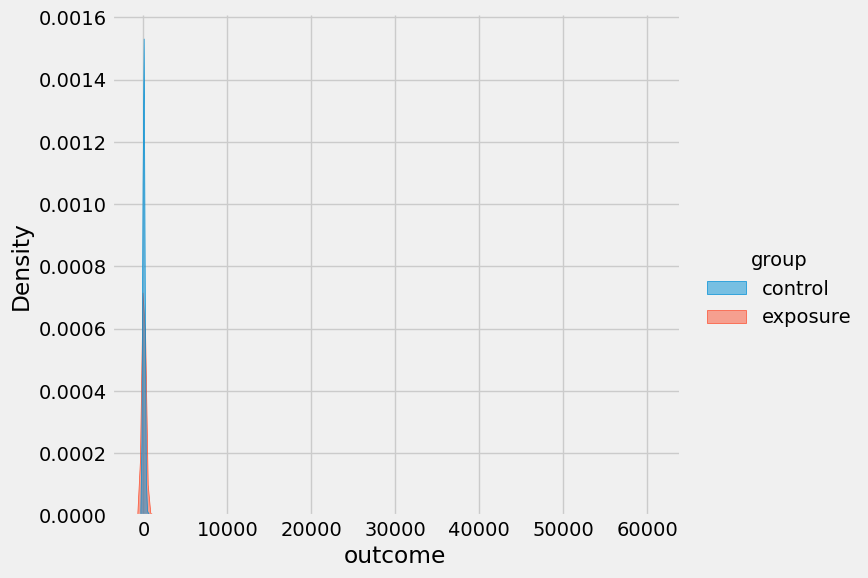

In [106]:
sns.displot(data=df_outlier_test, x='outcome', hue='group', kind='kde', fill=True, alpha=0.5, height=6, aspect=1.2)

In [108]:
# The difference in means is non-zero. This would suggests a "50.54% average lift."
(118.577615 - 78.767615)/78.767615

0.5054107579618855

In [110]:
# What does the t-test determine?
# The t-test determines that this is statistically significant 
stats.ttest_ind(a=df_outlier_test.query("group=='exposure'")['outcome'].values, 
                b=df_outlier_test.query("group=='control'")['outcome'].values, 
                equal_var=False)

Ttest_indResult(statistic=2.318034798946559, pvalue=0.020460954556823785)

In [111]:
# As expected, removing the outliers suggests non-significance. 
stats.ttest_ind(a=df_outlier_test.loc[(df_outlier_test['outcome'] <= 25514.456000)].query("group=='exposure'")['outcome'].values, 
                b=df_outlier_test.loc[(df_outlier_test['outcome'] <= 25514.456000)].query("group=='control'")['outcome'].values, 
                equal_var=False)

Ttest_indResult(statistic=0.0071612898155951465, pvalue=0.994286237726811)

In [112]:
# So the "result" is driven by 10 outliers

In [114]:
# What about a test of stochasitc domination? 
# Not statistically significant
stats.mannwhitneyu(x=df_outlier_test.query("group=='exposure'")['outcome'].values, y=df_outlier_test.query("group=='control'")['outcome'].values)

MannwhitneyuResult(statistic=50057505.0, pvalue=0.820915749448783)

In [115]:
# Let's try out the randomization inference approach
ri_2 = skewed_metric_utils.RandomizationInference()

Running randomization inference...
Number of distinct assignment combinations practically too large. Running 10000 simulated permutations


  0%|          | 0/10000 [00:00<?, ?it/s]

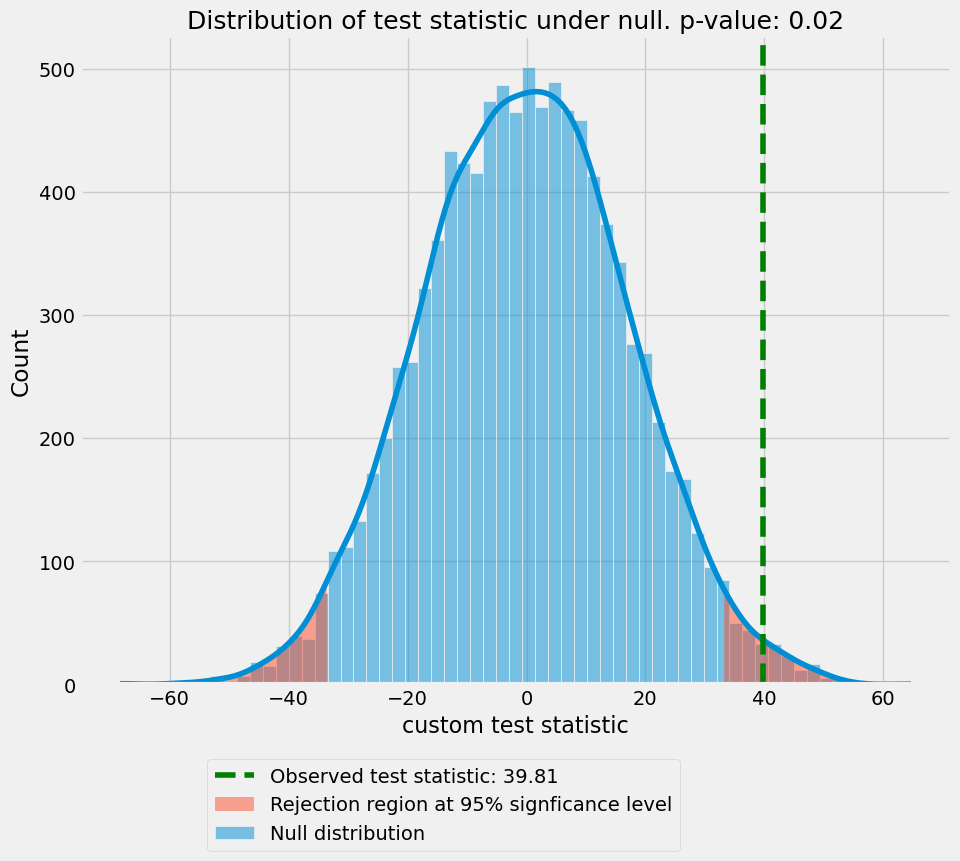

In [117]:
ri_2.experimental_analysis(df=df_outlier_test, 
                           outcome_column_name='outcome', 
                           treatment_column_name='group', 
                           treatment_name='exposure', 
                           control_name='control', num_permutations=10000, sample_with_replacement=True)

Interestingly enough, this agrees with the t-test (the p-values are essentially identical)

Running randomization inference...
Number of distinct assignment combinations practically too large. Running 10000 simulated permutations


  0%|          | 0/10000 [00:00<?, ?it/s]

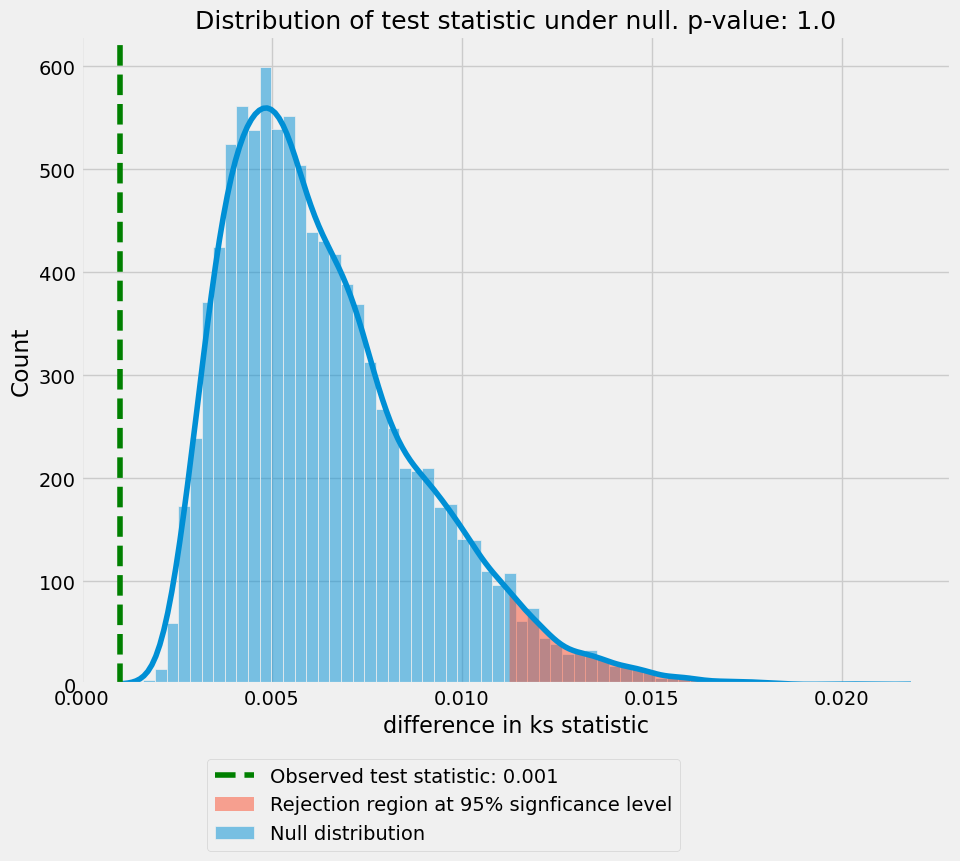

In [118]:
# As expected, the distribution is actually not different. This is the correct interpretation
ri_2.experimental_analysis(df=df_outlier_test, 
                           outcome_column_name='outcome', 
                           treatment_column_name='group', 
                           treatment_name='exposure', 
                           control_name='control', 
                           num_permutations=10000, 
                           sample_with_replacement=True, test_statistic={'function': 'difference_in_ks_statistic', 'params': None})

In [119]:
# Is it possible to measure a significant result with a t-test but not with randomization inference on the difference in means? The issue here might be
# the large sample size. What if we had like 10 times less observations?

In [236]:
sample_ = sorted(df_all.query("variant=='control'").sample(1000)['gamma_sim'].values)

In [247]:
mock_outliers = sample_

In [248]:
mock_outliers[0:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [249]:
mock_outliers[-1]

15304.734

In [250]:
mock_outliers = mock_outliers[2::]

In [251]:
len(mock_outliers)

998

In [252]:
mock_outliers = mock_outliers + [100000, 120000]
# mock_outliers = mock_outliers + [20000, 30000]

In [253]:
len(mock_outliers)

1000

In [254]:
group_labels = ['control'] * 1000 + ['exposure'] * 1000

In [255]:
outcomes_ = sample_ + mock_outliers 

In [256]:
df_outlier_test = pd.DataFrame()
df_outlier_test['group'] = group_labels
df_outlier_test['outcome'] = outcomes_

In [257]:
df_outlier_test.head()

,group,outcome
0,control,0.0
1,control,0.0
2,control,0.0
3,control,0.0
4,control,0.0


In [258]:
df_outlier_test.groupby('group').describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

outcome                                                       \
           count        mean          std  min  25%  50%  75%     90%   
group                                                                   
control   1000.0   75.191948   760.172533  0.0  0.0  0.0  0.0  0.0777   
exposure  1000.0  295.191948  4992.065773  0.0  0.0  0.0  0.0  0.0852   

                               
              95%         max  
group                          
control   15.7057   15304.734  
exposure  29.7946  120000.000

In [259]:
df_outlier_test.loc[(df_outlier_test['outcome'] > 15304.734)].groupby(['group'], as_index=False).count()

,group,outcome
0,exposure,2


In [260]:
# So the mean difference looks big, but it's driven entirely by 3 outliers. The relative difference is large ~292.6%
(295.191948 - 75.191948) / 75.191948

2.9258451982119156

<AxesSubplot: xlabel='group', ylabel='outcome'>

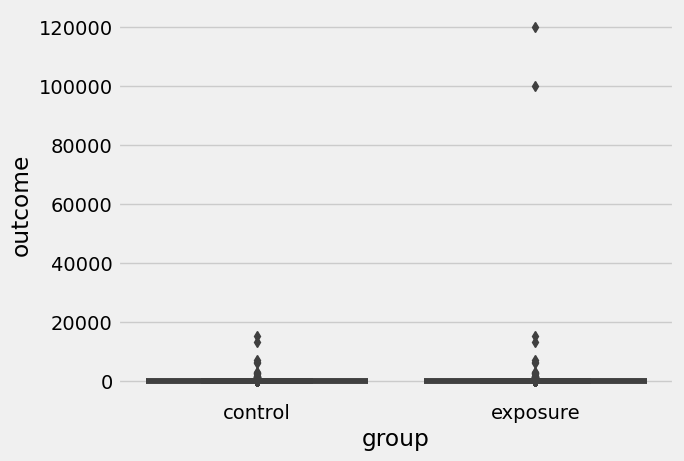

In [261]:
sns.boxplot(data=df_outlier_test, y='outcome', x='group')

In [263]:
# T-test is not stat-sig
stats.ttest_ind(a=df_outlier_test.query("group=='exposure'")['outcome'].values, 
                b=df_outlier_test.query("group=='control'")['outcome'].values)

Ttest_indResult(statistic=1.3777317212993339, pvalue=0.1684404239977226)

In [233]:
stats.ttest_ind(a=df_outlier_test.loc[(df_outlier_test['outcome'] <= 13336.407)].query("group=='exposure'")['outcome'].values, 
                b=df_outlier_test.loc[(df_outlier_test['outcome'] <= 13336.407)].query("group=='control'")['outcome'].values, 
                equal_var=False)

Ttest_indResult(statistic=0.01129414634896706, pvalue=0.9909910307964576)

In [234]:
ri_3 = skewed_metric_utils.RandomizationInference()

Running randomization inference...
Number of distinct assignment combinations practically too large. Running 10000 simulated permutations


  0%|          | 0/10000 [00:00<?, ?it/s]

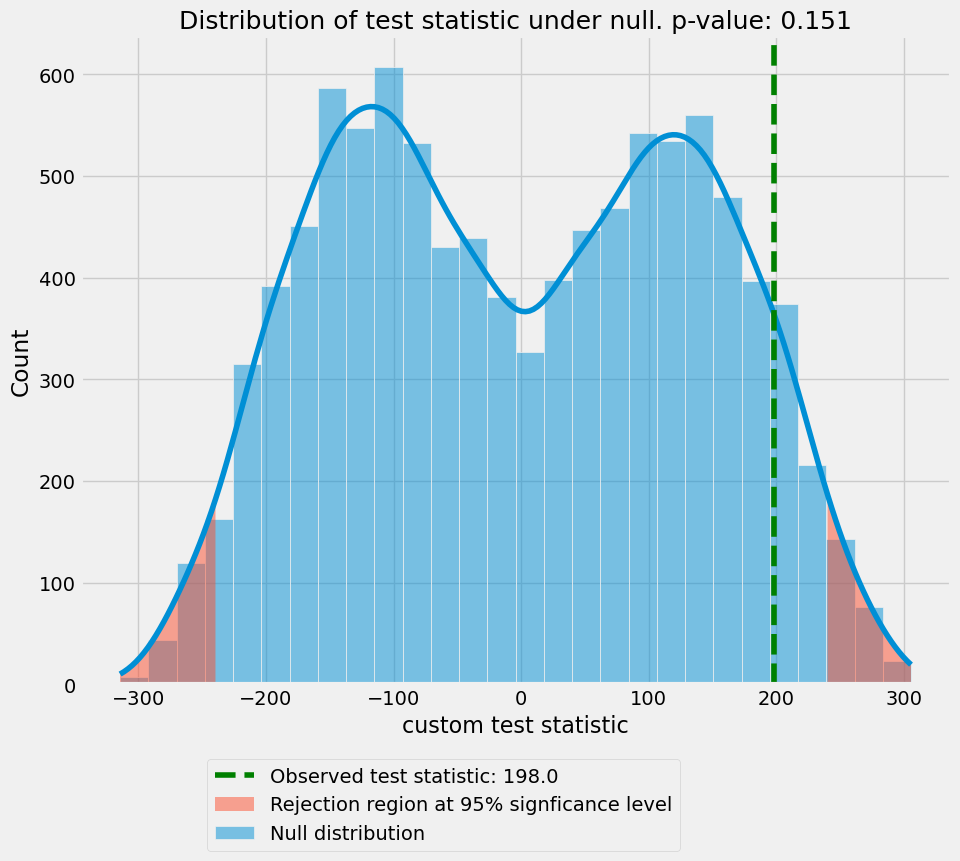

In [235]:
ri_3.experimental_analysis(df=df_outlier_test, 
                           outcome_column_name='outcome', 
                           treatment_column_name='group', 
                           treatment_name='exposure', 
                           control_name='control', num_permutations=10000, sample_with_replacement=True)

In [264]:
# What we really need here is a methodology to generate example data that we can use in the power calc method

We want to simulate historical data which is highly skewed. The skew is generally towards zero and is a mixture of actual zeros, censored values, and dropouts. We'll deal with the actual zeros and dropouts first, and assume that any experiment we run is sufficiently long that any "censored values" (i.e. people just haven't had the time to do the thing yet) are negligible (we may return to this later though).

The idea then is to design an experiment to detect a difference in an arbitrary test statistic given a percentage of the many zeros observed are actually dropouts (that percentage could be 0).  We use historical data to do this:

1. Simulate 6 months worth of historical data. This is about 183 days, or 26 weeks

2.  The data will represent the time at which a unit would have become eligible for the experiment. So for example on date 2023-10-12, unit 1 would have been assigned to either treatment or control (by some means) IF we had run the experiment on that day.  

3. Assign the outcomes from some distribution (in reality we'd use actual historical data to do this.)

4. This is the basis for a power calculation we can do with randomization inference. We'll adjust the sample size as follows:

    a. Remove all the dropouts, but retain the average dropout rate.  
    
    b. Do the power calculation on all non-dropout historical units and calculate the required sample size
    
    c. Inflate the returned sample size by the dropout rate.  
    
    e. For example, say the average dropout rate is 20%, and we calculate that we need a sample size (per group) of 10,000, then the total sample size is 20,000, and accounting for dropout, we'd need N*(1 - 0.2) = 20,000 => N = 25,000 as the total sample size. Might make more sense to calculate this per group. 

In [265]:
def simulate_expected_daily_visitors(number_of_days_for_experiment: int, daily_num_observations: int) -> pd.DataFrame:
    """
    Static method for simulating a count of daily experimental units for the AB test.  This uses the desired number of days for the simulated experiment and the expected daily average
    number of units that should qualify for the experiment to simulate a daily count of eligible units.  The count is assigned via a Poisson distribution. The returned DataFrame has two
    columns, one labels the days of the simulated experiment, and the other is just an integer 1, indicating a unique unit.  Grouping by the day column and summing the units column will
    give the total number of simulated experimental units observed per day

    :param number_of_days_for_experiment: Integer number of days you want to simulate the experiment for
    :param daily_num_observations: Integer average number of expected visitors per day
    :return: A DataFrame which labels each day in the experiment and a 1 for each unit observed on that day.

    """

    daily_units = []
    day_list = []
    for i in range(number_of_days_for_experiment):
        day_ = str(i)
        number_of_observations = np.random.poisson(daily_num_observations)
        observations = [1] * number_of_observations
        daily_units = daily_units + observations
        day_index = [day_] * number_of_observations
        day_list = day_list + day_index

    df_ = pd.DataFrame()
    df_['day'] = day_list
    df_['units'] = daily_units

    return df_

In [268]:
def assign_randomly(df: pd.DataFrame, n_variants: int = 2, p_vals: Union[list, str, np.ndarray] = 'equal', group_col: str = 'group') -> pd.DataFrame:
    """

    :param df:
    :param n_variants:
    :param p_vals:
    :param group_col:
    :return:
    """

    df_ = df.copy()

    if p_vals == 'equal':
        p_vals = [1.0 / n_variants] * n_variants
    else:
        assert type(p_vals) in [list, np.ndarray], "if p_vals is not 'equal', then it must be either a list or np.ndarray"
        assert sum(p_vals) == 1, "probabilities of assignment to each group {0} must sum to 1".format(p_vals)

    df_g = df_.groupby('day', as_index=False).sum()
    assignment = []
    for day_, num_obs in zip(df_g['day'].values, df_g['units'].values):
        assignments_ = np.random.multinomial(n=1, pvals=p_vals, size=num_obs)
        assignments_ = [np.argmax(x) for x in assignments_]
        assignment = assignment + list(assignments_)
    df_[group_col] = assignment
    df_[group_col] = df_[group_col].apply(lambda x: 'control' if x == 0 else 'treatment_{0}'.format(x))

    return df_

In [269]:
# We should be able to leverage a lot of what we already built for the AB test results

In [297]:
# In this case, this is the length of time for the historical data we are simulating
number_of_days_for_experiment = 183
# This is completely made up
daily_num_observations = 10000

In [298]:
df_sim = simulate_expected_daily_visitors(number_of_days_for_experiment=183, daily_num_observations=daily_num_observations)

In [299]:
df_sim.shape

(1828850, 2)

In [300]:
df_sim.head()

,day,units
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [301]:
# Let's also add hypothetical dates as an option
hypothetical_start_date = datetime.datetime(2023, 1, 1)
hypothetical_end_date = hypothetical_start_date + datetime.timedelta(days=number_of_days_for_experiment)

In [302]:
hypothetical_end_date

datetime.datetime(2023, 7, 3, 0, 0)

In [303]:
date_list = [hypothetical_start_date + datetime.timedelta(days=x) for x in range(number_of_days_for_experiment)]

In [304]:
len(date_list)

183

In [305]:
date_map = {str(i): d for i, d in enumerate(date_list)}

In [306]:
df_sim['date'] = df_sim['day'].map(date_map)

In [307]:
df_sim.head()

,day,units,date
0,0,1,2023-01-01
1,0,1,2023-01-01
2,0,1,2023-01-01
3,0,1,2023-01-01
4,0,1,2023-01-01


In [308]:
df_sim['date'].nunique()

183

In [309]:
# Ok. 
# df_sim = assign_randomly(df=df_sim, n_variants=2, p_vals=[0.5, 0.5], group_col='variant')

In [310]:
# df_sim.head()

In [311]:
# df_sim[['date', 'variant', 'units']].groupby(['date', 'variant']).sum()

In [295]:
# Yep, looks good. We should try and add some more variance into the count approximations though

In [296]:
# You know, we can actually skip this assignment step, this is meant to be historical data
# We'll come back to generating a skewed continuous experiment outcome

In [312]:
df_sim.head()

,day,units,date
0,0,1,2023-01-01
1,0,1,2023-01-01
2,0,1,2023-01-01
3,0,1,2023-01-01
4,0,1,2023-01-01


In [313]:
d_ = '0'

In [316]:
outcomes_ = []
for d_ in df_sim['day'].unique():
    num_samples = df_sim.query("day=='{0}'".format(d_))['units'].sum()
    # Make this customizable
    r = list(stats.gamma.rvs(size=num_samples, a=0.01, scale=10000))
    outcomes_ = outcomes_ + r

In [317]:
df_sim['outcome'] = outcomes_
df_sim['outcome'] = df_sim['outcome'].progress_apply(lambda x: np.round(x, 3))

  0%|          | 0/1828850 [00:00<?, ?it/s]

In [318]:
df_sim.head()

,day,units,date,outcome
0,0,1,2023-01-01,0.000
1,0,1,2023-01-01,0.000
2,0,1,2023-01-01,0.000
3,0,1,2023-01-01,0.266
4,0,1,2023-01-01,0.000


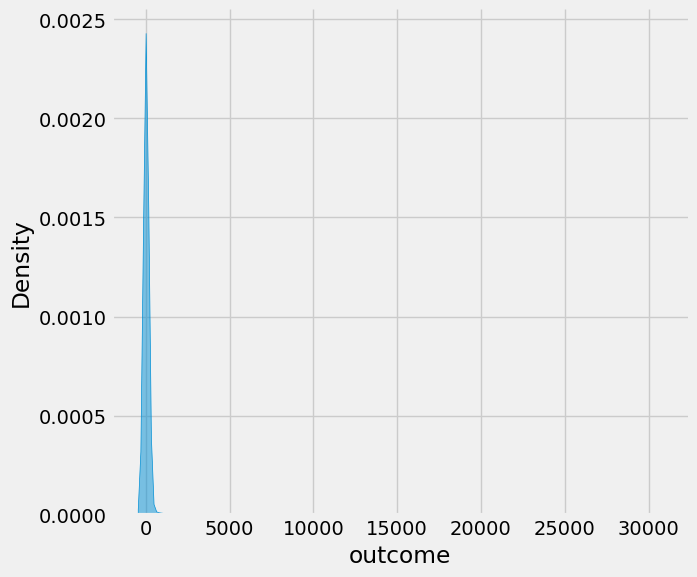

In [320]:
# Let's pick a random day
sns.displot(data=df_sim.query("day=='12'"), x='outcome', kind='kde', fill=True, alpha=0.5, height=6, aspect=1.2)

In [321]:
df_sim['outcome'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

count    1.828850e+06
mean     1.020904e+02
std      1.022947e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
90%      1.500000e-01
95%      3.391955e+01
max      1.151336e+05
Name: outcome, dtype: float64

In [322]:
# Ok this looks like what we'd expect. Now let's add the dropouts.
# We can model this like a assignment problem to two treatment groups, except the probability of dropout is 0 if the outcomes is positive

In [323]:
dropout_prob = 0.4

In [333]:
# We can actually just do this:
df_zeros = df_sim.query("outcome==0")
df_not_zeros = df_sim.query("outcome > 0")

In [334]:
df_zeros.shape

(1554336, 6)

In [335]:
dropout_labels = np.random.binomial(n=1, p=dropout_prob, size=df_zeros.shape[0])

In [337]:
np.sum(dropout_labels)

621947

In [338]:
621947/1554336

0.40013677866304326

In [339]:
df_zeros['is_dropout'] = dropout_labels
df_not_zeros['is_dropout'] = 0

In [340]:
df_sim_with_do = pd.concat([df_zeros, df_not_zeros])
df_sim_with_do = df_sim_with_do.sort_values(by='date', ascending=True)

In [341]:
df_sim_with_do.head()

,day,units,date,outcome,dropout_prob,is_dropout
0,0,1,2023-01-01,0.0,0.4,1
7891,0,1,2023-01-01,0.0,0.4,1
7892,0,1,2023-01-01,0.0,0.4,0
7894,0,1,2023-01-01,0.0,0.4,0
7895,0,1,2023-01-01,0.0,0.4,1


In [ ]:
df_sim_with_do['is_drop']